In [1]:
!pip install torchsummary
!pip install torchgeometry
!pip install segmentation-models-pytorch

In [2]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb

In [3]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s] 


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Paramaters

In [5]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 50

# Hyperparameters for training 
learning_rate = 1e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

# Data Loader and Augmentation

In [6]:
torch.manual_seed(42)

In [7]:
from albumentations import (
    Compose as ACompose,
    RandomRotate90,
    Flip,
    Transpose,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomBrightnessContrast,
    HorizontalFlip,
    VerticalFlip,
    RandomGamma,
    RGBShift,
)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

In [9]:
class SegDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform=None, augmentation=None):
        super(SegDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        # Augmentation
        if self.augmentation:
            augmented = self.augmentation(image=np.array(data), mask=np.array(label))
            data = Image.fromarray(augmented['image'])
            label = Image.fromarray(augmented['mask'])
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label > 0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [10]:
transform = Compose([
    Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    PILToTensor()
])

In [11]:
augmentation = ACompose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomGamma(gamma_limit=(70, 130), p=0.2),
    RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3)
])

In [12]:
# transform = transforms.ToTensor()
aug_dataset = SegDataClass(images_path, masks_path, transform=transform, augmentation=augmentation)

In [13]:
train_size = 0.9
valid_size = 0.1

In [14]:
train_aug_set, valid_aug_set = random_split(aug_dataset, 
                                    [int(train_size * len(aug_dataset)) , 
                                     int(valid_size * len(aug_dataset))])

In [15]:
train_dataloader = DataLoader(train_aug_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_aug_set, batch_size=batch_size, shuffle=True)

# Model 

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)

        out += residual  
        out = self.relu(out)

        return out

In [17]:
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

In [18]:
class res_encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(res_encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)
        
        
        x += residual  
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

In [19]:
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [20]:
class res_decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(res_decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)
        
        x += residual
        x = self.relu(x)
        
        return x

In [21]:
class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [22]:
# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = res_encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = ResidualBlock(512, 1024)
        
        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = res_decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        
        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        
        n5 = self.bottleneck(n4)
        
        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)
        
        output = self.out(n9)
        
        return output

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CEDiceLoss(nn.Module):
    def __init__(self, weights: torch.Tensor) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        if not (torch.is_tensor(input) and input.device == target.device):
            raise ValueError("Input and target must be tensors on the same device.")
        if input.shape[-2:] != target.shape[-2:]:
            raise ValueError("Input and target shapes must match in height and width.")
        if self.weights.shape[1] != input.shape[1]:
            raise ValueError("Number of weights must equal the number of classes.")
        if not torch.isclose(torch.sum(self.weights), torch.tensor(1.0)):
            raise ValueError("The sum of all weights must equal 1.")
        
        # Compute cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # Compute softmax probabilities
        input_soft = F.softmax(input, dim=1)

        # Convert target to one-hot representation
        target_one_hot = F.one_hot(target, num_classes=input.shape[1]).permute(0, 3, 1, 2).float()

        # Compute Dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)
        dice_score = 2. * intersection / (cardinality + self.eps)
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss


# Training

In [24]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [25]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [26]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [27]:
# model = Unet(in_channels=3, num_classes = 3)

try:
    checkpoint = torch.load(pretrained_path)

    new_state_dict = OrderedDict()
    for k, v in checkpoint['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model)
    model.to(device)
except:
    model.apply(weights_init)
    model = nn.DataParallel(model)
    model.to(device)

/tmp/ipykernel_239/439225604.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_path)


In [28]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
try: 
    optimizer.load_state_dict(checkpoint['optimizer'])
except:
    pass

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [29]:
save_model(model, optimizer, checkpoint_path)

In [31]:
import wandb
import os

# Function to prompt the user for their WandB API key
def get_wandb_key():
    api_key = input("Please enter your WandB API key: ")
    return api_key

# Check if the API key is already set in the environment
wandb_key = os.getenv("WANDB_API_KEY")

if not wandb_key:
    # If the key is not set, prompt the user
    wandb_key = get_wandb_key()

# Log in to WandB
wandb.login(key=wandb_key)

# Initialize your project
wandb.init(project="Semantic Segmentation")

Please enter your WandB API key:  7af581cdfcbe6f08a616c784585d1e72b9488604


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phong-tdd (phong-tdd-hust). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})

Start epoch #1, learning rate for this epoch: [0.0001]


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Train Epoch: 1 [200/900 (22.22222222222222%)]	Loss: 1.6866
Train Epoch: 1 [400/900 (44.44444444444444%)]	Loss: 1.2747
Train Epoch: 1 [600/900 (66.66666666666667%)]	Loss: 1.4251
Train Epoch: 1 [800/900 (88.88888888888889%)]	Loss: 0.9271
Done epoch #1, time for this epoch: 72.54009103775024s
Start epoch #2, learning rate for this epoch: [0.0001]
Train Epoch: 2 [200/900 (22.22222222222222%)]	Loss: 0.8679
Train Epoch: 2 [400/900 (44.44444444444444%)]	Loss: 1.2189
Train Epoch: 2 [600/900 (66.66666666666667%)]	Loss: 0.8698
Train Epoch: 2 [800/900 (88.88888888888889%)]	Loss: 1.0073
Done epoch #2, time for this epoch: 63.4050133228302s
Start epoch #3, learning rate for this epoch: [0.0001]
Train Epoch: 3 [200/900 (22.22222222222222%)]	Loss: 0.8689
Train Epoch: 3 [400/900 (44.44444444444444%)]	Loss: 1.0380
Train Epoch: 3 [600/900 (66.66666666666667%)]	Loss: 0.8671
Train Epoch: 3 [800/900 (88.88888888888889%)]	Loss: 1.3959
Done epoch #3, time for this epoch: 63.33070254325867s


# Create submission

In [33]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [34]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)

In [35]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

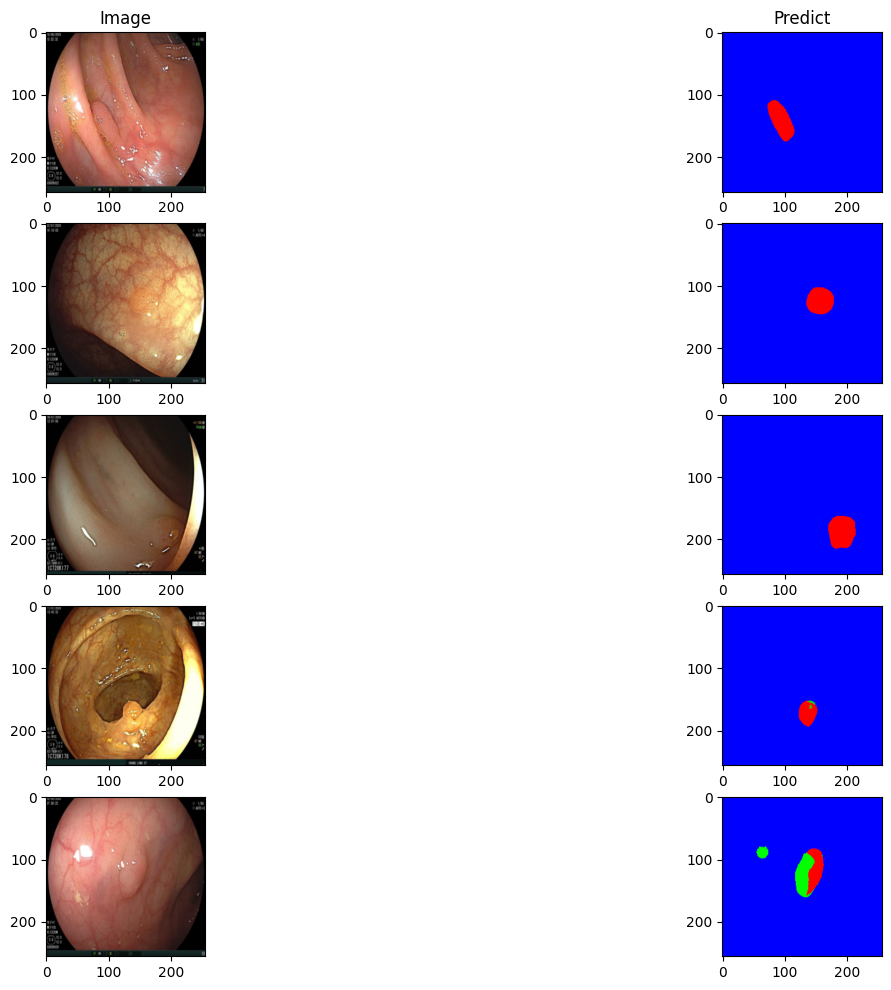

In [36]:
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [37]:
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [38]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'submission.csv', index=False)

/kaggle/working/predicted_masks/d077bad31c8c5f54ffaa27a623511c38.png
/kaggle/working/predicted_masks/1209db6dcdda5cc8a788edaeb6aa460a.png
/kaggle/working/predicted_masks/e2cd066b9fdbc3bbc04a3afe1f119f21.png
/kaggle/working/predicted_masks/4baddc22268d4b4ef4d95ceea1195799.png
/kaggle/working/predicted_masks/1c0e9082ea2c193ac8d551c149b60f29.png
/kaggle/working/predicted_masks/5664c1711b62f15ec83b97bb11e8e0c4.png
/kaggle/working/predicted_masks/45b21960c94b0aab4c024a573c692195.png
/kaggle/working/predicted_masks/ff55177a34fc01019eec999fd84e679b.png
/kaggle/working/predicted_masks/dc70626ab4ec3d46e602b296cc5cfd26.png
/kaggle/working/predicted_masks/d5060a633a8d5b2b2b55157b7781e2c7.png
/kaggle/working/predicted_masks/ff05dec1eb3a70b145a7d8d3b6c0ed75.png
/kaggle/working/predicted_masks/f8e26031fbb5e52c41545ba55aadaa77.png
/kaggle/working/predicted_masks/0fca6a4248a41e8db8b4ed633b456aaa.png
/kaggle/working/predicted_masks/df366e057db382b8564872a27301a654.png
/kaggle/working/predicted_masks/fd